In [2]:
import numpy as np
import scanpy as sc
import anndata as ad
import os
import scipy as sp
from collections import Counter
from matplotlib.pyplot import rc_context

from prosstt import tree
from prosstt import simulation as sim
from prosstt import sim_utils as sut

data_dir = '../Data'
fig_dir = 'figures/'

In [3]:
title_font_size=12
label_font_size=10
figsize=(10,10)

rseed = 25
np.random.seed(rseed)

# Producing Simulation

### Define topology and parameters for simulation

In [4]:
#4 lineages, no split, extra branch on each
top = [["A", "B"], ["B", "C"], ["C", "D"], ["A", "E"], ["E", "F"], ["F", "G"], ["A", "H"], ["H", "I"], ["I", "K"], ["A", "L"], ["L", "M"], ["M", "O"]]

In [5]:
branches = np.unique(np.array(top).flatten())
time = {b: 50 for b in branches}
G = 5000
t = tree.Tree(topology=top, G=G, time=time, num_branches=len(branches), branch_points=1, modules=50)
mya = np.min([0.05, 1 / t.modules])

In [6]:
uMs, Ws, Hs = sim.simulate_lineage(t, a=mya, intra_branch_tol=-1, inter_branch_tol=0)

c:\users\uqewats6\miniconda3\envs\distance\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [7]:
#Add genes to tree
gene_scale = sut.simulate_base_gene_exp(t, uMs)
t.add_genes(uMs, gene_scale)

In [9]:
#Sample Variance - normal range for average, variance
alpha = np.exp(np.random.normal(loc=np.log(0.2), scale=np.log(1.5), size=t.G))
beta = np.exp(np.random.normal(loc=np.log(1), scale=np.log(1.5), size=t.G)) + 1

### Sample cells from simulation

In [10]:
X, labs, brns, scalings = sim.sample_whole_tree(t, 10, alpha=alpha, beta=beta) #returns matrix (X), pseudotime values (labs), 

# Producing Datasets for structural categories

## Abundant Datasets

### Construct and save Continuous Abundant dataframe

In [12]:
data = ad.AnnData(X)
data.obs['pseudotime']=labs
data.obs['branch']=brns
data.obs['scalings'] = scalings

# normalize gene expression by library size
Xa = (X.transpose() / scalings).transpose()
data.layers['normalised'] = np.log(Xa+1)

#Continuous Abundant dataset
data.write(os.path.join(data_dir,'Continous_Abundant_Simulation_Raw.h5ad'))

### Subset to produce and save Discrete Abundant dataframe

In [15]:
#Discrete abundant dataset
subset = data[data.obs['branch'].isin(['A','D','K','G','O'])]
subset.write(os.path.join(data_dir,'Discrete_Abundant_Simulation_Raw.h5ad')

In [16]:
data

AnnData object with n_obs × n_vars = 6500 × 5000
    obs: 'pseudotime', 'branch', 'scalings'
    layers: 'normalised'

In [17]:
subset

View of AnnData object with n_obs × n_vars = 2500 × 5000
    obs: 'pseudotime', 'branch', 'scalings'
    layers: 'normalised'

### Visualise datasets

In [18]:
#create for vis
# normalize gene expression by library size
X = (X.transpose() / scalings).transpose()
dat = ad.AnnData(np.log(X+1))
dat.obs['pseudotime']=labs
dat.obs['branch']=brns
dat.obs['scalings'] = scalings

subdat = dat[dat.obs['branch'].isin(['A', 'D', 'K', 'G','O'])]

c:\users\uqewats6\miniconda3\envs\distance\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'branch' as categorical


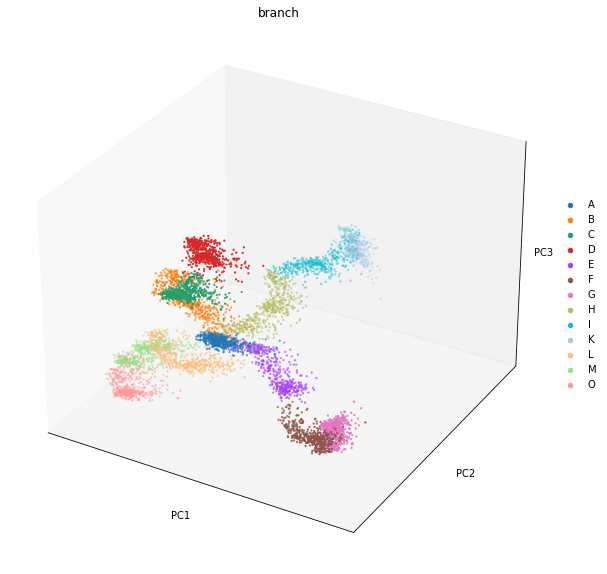

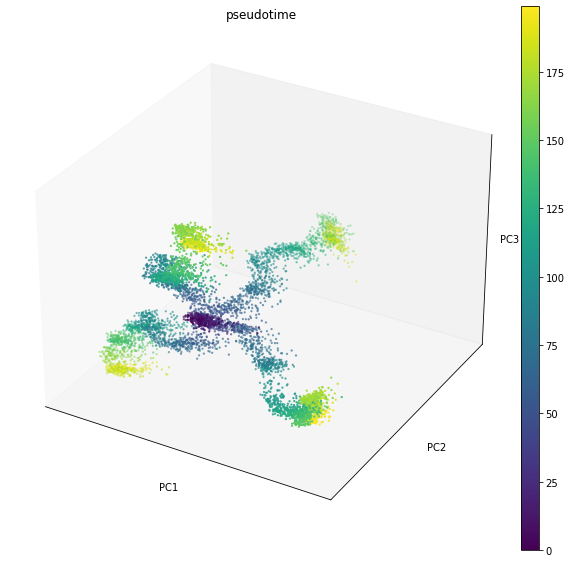

In [19]:
sc.tl.pca(dat, n_comps=3, random_state=100)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.pca(dat, projection='3d', color='branch', title = 'branch')
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.pca(dat, projection='3d', color='pseudotime', title = 'pseudotime')

c:\users\uqewats6\miniconda3\envs\distance\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'branch' as categorical


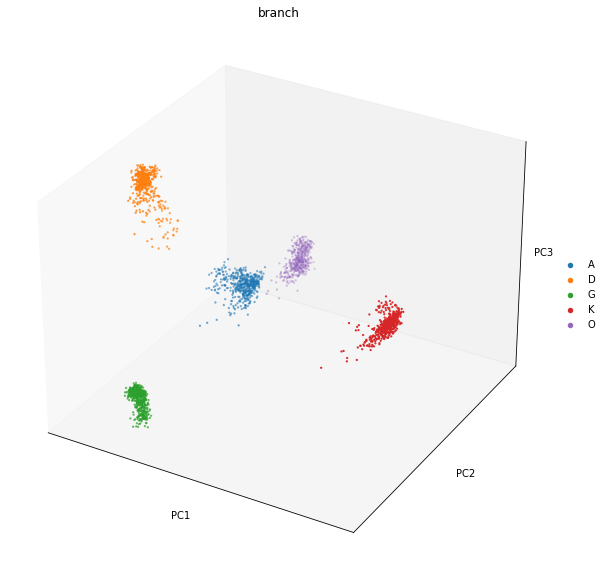

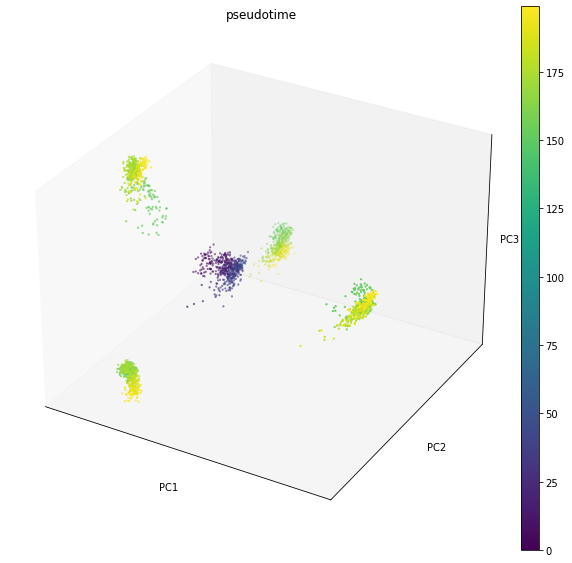

In [20]:
sc.tl.pca(subdat, n_comps=3, random_state=100)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.pca(subdat, projection='3d', color='branch', title = 'branch')
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.pca(subdat, projection='3d', color='pseudotime', title = 'pseudotime')

## Moderately-Rare datasets

In [21]:
np.random.seed(11)
Cont_abund = data
Disc_abund = subset

### Construct and save Continuous Moderately-Rare dataset

In [22]:
Cont_adatas = [Cont_abund[Cont_abund.obs['branch'].isin([branch_num])] for branch_num in Cont_abund.obs['branch'].unique()]
Cont_target_fractions = [0.8, 0.22, 0.06, 0.02, 0.02, 0.22, 0.06, 0.06, 0.02, 0.22, 0.22, 0.02, 0.06]
for dat, frac in zip(Cont_adatas, Cont_target_fractions):
         dat = sc.pp.subsample(data=dat, fraction=frac)

In [24]:
Cont_rare = Cont_adatas[0].concatenate(*Cont_adatas[1:])
Cont_rare.write(os.path.join(data_dir,'Continous_Rare_Simulation_Raw.h5ad'))

### Construct and save Discrete Moderately-Rare datasets

In [25]:
Disc_adatas = [Disc_abund[Disc_abund.obs['branch'].isin([branch_num])] for branch_num in Disc_abund.obs['branch'].unique()]
Disc_target_fractions = [0.02, 0.06, 0.32, 0.6, 1]
for dat, frac in zip(Disc_adatas, Disc_target_fractions):
         dat = sc.pp.subsample(data=dat, fraction=frac)

In [26]:
Disc_rare = Disc_adatas[0].concatenate(*Disc_adatas[1:])
Disc_rare.write(os.path.join(data_dir,'Discrete_Rare_Simulation_Raw.h5ad'

### Visualise datasets

c:\users\uqewats6\miniconda3\envs\distance\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'branch' as categorical


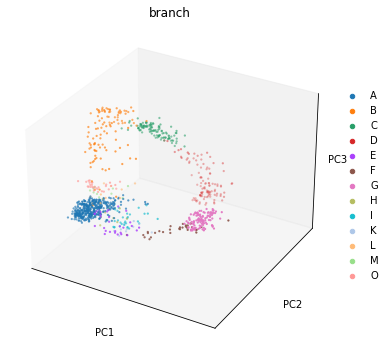

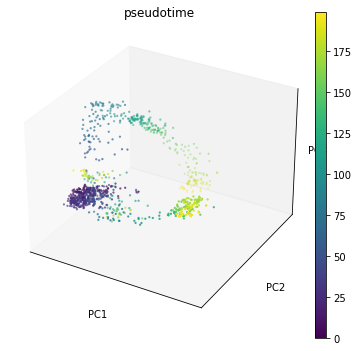

In [27]:
from matplotlib.pyplot import rc_context
Cont_rare.obsm['X_pca'] = sc.tl.pca(Cont_rare.layers['normalised'], n_comps=3, random_state=11)
with rc_context({'figure.figsize': (6, 6)}):
     sc.pl.pca(Cont_rare, layer='normalised', projection='3d', color='branch')
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.pca(Cont_rare, layer='normalised', projection='3d', color='pseudotime')

c:\users\uqewats6\miniconda3\envs\distance\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'branch' as categorical


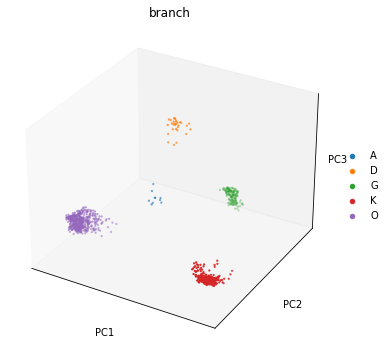

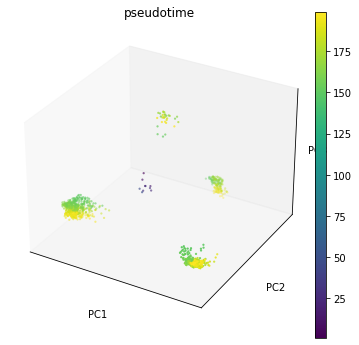

In [28]:
from matplotlib.pyplot import rc_context
Disc_rare.obsm['X_pca'] = sc.tl.pca(Disc_rare.layers['normalised'], n_comps=3, random_state=7)
with rc_context({'figure.figsize': (6, 6)}):
     sc.pl.pca(Disc_rare, layer='normalised', projection='3d', color='branch')
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.pca(Disc_rare, layer='normalised', projection='3d', color='pseudotime')

## Ultra-Rare Datasets

In [29]:
Cont_abund = data
Disc_abund = subset

### Construct and save Continuous Ultra-Rare dataset

In [30]:
Cont_adatas = [Cont_abund[Cont_abund.obs['branch'].isin([branch_num])] for branch_num in Cont_abund.obs['branch'].unique()]
Cont_target_fractions = [1, 0.23, 0.014, 0.006, 0.006, 0.23, 0.014, 0.014, 0.006, 0.23, 0.23, 0.006, 0.014]
for dat, frac in zip(Cont_adatas, Cont_target_fractions):
         dat = sc.pp.subsample(data=dat, fraction=frac)

In [31]:
Cont_ultrarare = Cont_adatas[0].concatenate(*Cont_adatas[1:])
Cont_ultrarare.write(os.path.join(data_dir,'Continous_UltraRare_Simulation_Raw.h5ad')

### Construct and save Discrete Ultra-Rare datasets

In [32]:
Disc_adatas = [Disc_abund[Disc_abund.obs['branch'].isin([branch_num])] for branch_num in Disc_abund.obs['branch'].unique()]
Disc_target_fractions = [0.006, 0.014, 0.08, 0.9, 1]
for dat, frac in zip(Disc_adatas, Disc_target_fractions):
         dat = sc.pp.subsample(data=dat, fraction=frac)

In [33]:
Disc_ultrarare = Disc_adatas[0].concatenate(*Disc_adatas[1:])
Disc_ultrarare.write(os.path.join(data_dir,'Discrete_UltraRare_Simulation_Raw.h5ad'))

### Visualise datasets

c:\users\uqewats6\miniconda3\envs\distance\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'branch' as categorical


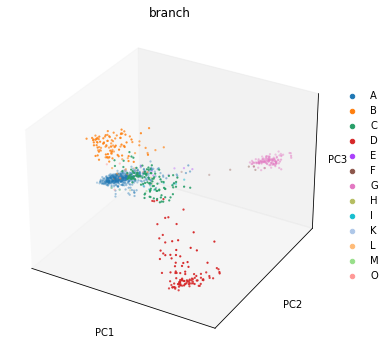

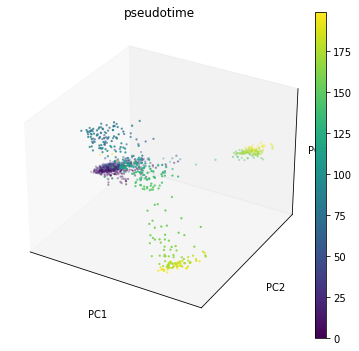

In [34]:
from matplotlib.pyplot import rc_context
Cont_ultrarare.obsm['X_pca'] = sc.tl.pca(Cont_ultrarare.layers['normalised'], n_comps=3, random_state=11)
with rc_context({'figure.figsize': (6, 6)}):
     sc.pl.pca(Cont_ultrarare, layer='normalised', projection='3d', color='branch')
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.pca(Cont_ultrarare, layer='normalised', projection='3d', color='pseudotime')

c:\users\uqewats6\miniconda3\envs\distance\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'branch' as categorical


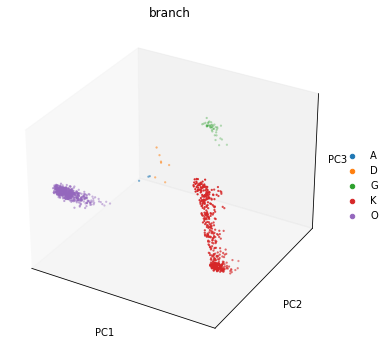

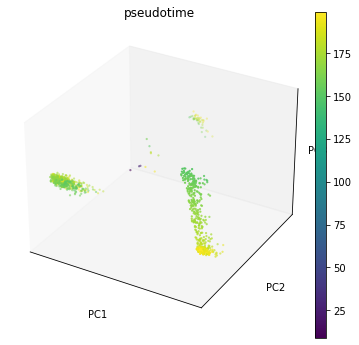

In [35]:
from matplotlib.pyplot import rc_context
Disc_ultrarare.obsm['X_pca'] = sc.tl.pca(Disc_ultrarare.layers['normalised'], n_comps=3, random_state=7)
with rc_context({'figure.figsize': (6, 6)}):
     sc.pl.pca(Disc_ultrarare, layer='normalised', projection='3d', color='branch')
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.pca(Disc_ultrarare, layer='normalised', projection='3d', color='pseudotime')

# Produce and save out Processed datasets

In [36]:
datasets = {
    'Discrete Abundant': subset,
    'Discrete Moderately-Rare': Disc_rare,
    'Discrete Ultra-Rare': Disc_ultrarare,
    'Continuous Abundant': data,
    'Continuous Moderately-Rare': Cont_rare,
    'Continuous Ultra-Rare': Cont_ultrarare
}

In [ ]:
for dataset in datasets.keys():
    if sp.sparse.isspmatrix_csr(datasets[dataset].X) == False: #Convert all to CSR if not already
        sp.sparse.csr_matrix(datasets[dataset].X)
    sc.pp.calculate_qc_metrics(datasets[dataset], percent_top=None, log1p=False, inplace=True)
    sc.pp.filter_cells(datasets[dataset], min_genes=200, inplace=True) #Filter cells expression >200 genes
    sc.pp.filter_genes(datasets[dataset], min_cells=(len(datasets[dataset].obs)*0.1), inplace=True) #Filter genes expressed in <10% of cells
    sc.pp.normalize_total(datasets[dataset], target_sum=1e4, key_added='norm_factor')
    sc.pp.log1p(datasets[dataset])

In [ ]:
for dataset in datasets.keys():
    datasets[dataset].write(os.path.join(data_dir, dataset + '_5kG_10C_Simulation_Processed.h5ad'))